# VPD control using automatic sprinklers system

- toc: true 
- badges: true
- comments: false
- categories: [jupyter]

In [2]:
import urllib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os.path
import matplotlib.dates as mdates
import datetime as dt
import matplotlib as mpl
from pandas.tseries.frequencies import to_offset
from scipy.signal import savgol_filter
from matplotlib.patches import Wedge
import turtle


Download data from Thingspeak

In [75]:
filename1 = "the_projectX.csv"
# if file is not there, go fetch it from thingspeak
if not os.path.isfile(filename1):
    # define what to download
    channels = "1708067"
    fields = "1,2,3"
    minutes = "30"

    # https://www.mathworks.com/help/thingspeak/readdata.html
    # format YYYY-MM-DD%20HH:NN:SS
    start = "2022-07-14%2012:00:00"
    end = "2022-07-14%2018:00:00"

    # download using Thingspeak's API
    # url = f"https://api.thingspeak.com/channels/{channels}/fields/{fields}.csv?minutes={minutes}"
    url = f"https://api.thingspeak.com/channels/{channels}/fields/{fields}.csv?start={start}&end={end}"
    data = urllib.request.urlopen(url)
    d = data.read()

    # save data to csv
    file = open(filename1, "w")
    file.write(d.decode('UTF-8'))
    file.close()


crating a new Data frame

In [76]:
# load data
df = pd.read_csv(filename1)
# rename columns
df = df.rename(columns={"created_at": "timestamp",
                        "field1": "Temp",
                        "field2": "RH",
                        "field3": "VPD",})
# set timestamp as index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
df

,entry_id,Temp,RH,VPD
timestamp,,,,
2022-07-14 12:01:45+00:00,367580,35.97,74.73,1.49845
2022-07-14 12:03:56+00:00,367581,36.09,71.24,1.71667
2022-07-14 12:06:05+00:00,367582,36.17,72.79,1.63129
2022-07-14 12:08:14+00:00,367583,36.15,73.04,1.61453
2022-07-14 12:10:25+00:00,367584,36.07,73.44,1.58361
...,...,...,...,...
2022-07-14 15:55:34+00:00,367690,28.12,84.34,0.59595
2022-07-14 15:57:40+00:00,367691,28.09,84.92,0.57288
2022-07-14 15:59:47+00:00,367692,28.03,84.84,0.57391


### First graph

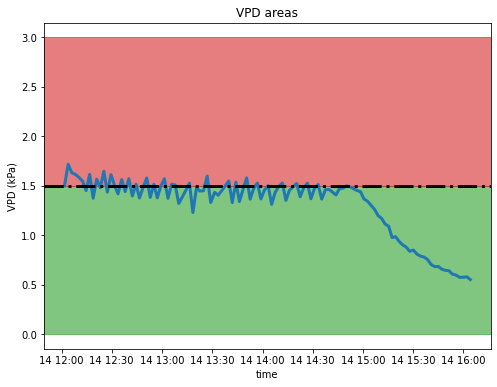

In [77]:
# %matplotlib widget

fig, ax = plt.subplots(1, figsize=(8,6))

ax.plot(df['VPD'], linewidth=3)
# add labels and title
ax.set(xlabel = "time",
       ylabel = "VPD (kPa)",
       title = "VPD areas")
# makes slanted dates
# Plot a horizontal line using axhline() in pyplot
plt.axhline(y=1.5, color='black', linestyle='-.', linewidth=3)
ax.axhspan(0, 1.5,color='tab:green',alpha=0.6)
ax.axhspan(1.5,3,color='tab:red',alpha=0.6)
plt.show()


### The Temp and the RH

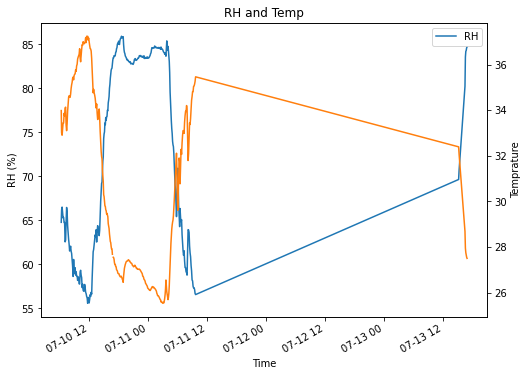

In [52]:
# %matplotlib widget

fig, ax = plt.subplots(1, figsize=(8,6))

ax.plot(df['RH'], color="tab:blue", label="RH")
# add labels and title
ax.set(xlabel = "Time",
       ylabel = "RH (%)",
       title = "RH and Temp",
       )
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df['Temp'], color="tab:orange", label="Temperature")
ax2.set_ylabel("Temprature")
# makes slanted dates
plt.gcf().autofmt_xdate()
ax.legend(loc="upper right")

### Calculate outside VPD 

We took data from other project to cheak how does our seystem work comper the regular VPD.

In [78]:
filename2 = "the_other_data1.csv"
# if file is not there, go fetch it from thingspeak
if not os.path.isfile(filename2):
    # define what to download
    channels = "1690485"
    fields = "1,2,6"
#     minutes = "30"

   # https://www.mathworks.com/help/thingspeak/readdata.html
    # format YYYY-MM-DD%20HH:NN:SS
    start = "2022-07-14%2012:00:00"
    end = "2022-07-14%2018:00:00"

    # download using Thingspeak's API
    # url = f"https://api.thingspeak.com/channels/{channels}/fields/{fields}.csv?minutes={minutes}"
    url = f"https://api.thingspeak.com/channels/{channels}/fields/{fields}.csv?start={start}&end={end}"
    data = urllib.request.urlopen(url)
    d = data.read()

    # save data to csv
    file = open(filename2, "w")
    file.write(d.decode('UTF-8'))
    file.close()


In [79]:
# load data
df2 = pd.read_csv(filename2)
# rename columns
df2 = df2.rename(columns={"created_at": "timestamp",
                        "field1": "Temp2",
                        "field2": "RH2",
                        "field6": "VPD2",})
# set timestamp as index
df2['timestamp'] = pd.to_datetime(df2['timestamp'])
df2 = df2.set_index('timestamp')
df2

,entry_id,Temp2,RH2,VPD2
timestamp,,,,
2022-07-14 12:00:06+00:00,24268,39.11,46.07,3.75911
2022-07-14 12:00:32+00:00,24269,38.90,45.26,3.77293
2022-07-14 12:01:02+00:00,24270,38.73,45.47,3.72437
2022-07-14 12:01:27+00:00,24271,38.87,45.77,3.73178
2022-07-14 12:01:54+00:00,24272,39.02,44.60,3.84303
...,...,...,...,...
2022-07-14 16:03:39+00:00,24827,25.29,86.11,0.44481
2022-07-14 16:04:08+00:00,24828,25.29,86.33,0.43776
2022-07-14 16:04:35+00:00,24829,25.25,86.54,0.43002


In [17]:
def calculate_es(T):
    es = np.exp((16.78 * T - 116.9) / (T + 237.3))
    return es

def calculate_ed(es, rh):
    return es * rh / 100.0

es = calculate_es(df['Temp2'])
ed = calculate_ed(es, df['RH2'])
df['VPD2'] = es - ed

See if what you calculated makes sense.

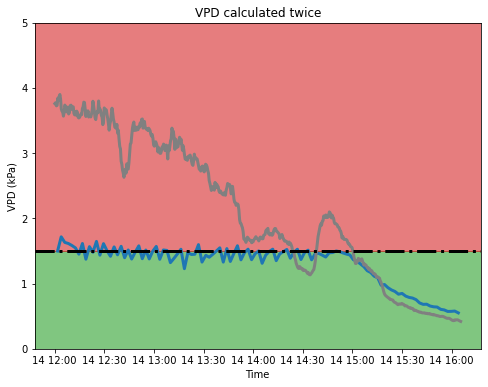

<Figure size 432x288 with 0 Axes>

In [86]:
# %matplotlib widget

fig, ax = plt.subplots(1, figsize=(8,6))

ax.plot(df['VPD'], color="tab:blue", label="VPD inside the mini greenhouse",linewidth=3)
ax.plot(df2['VPD2'], color="gray", label="VPD ouside",linewidth=3)
# add labels and title
ax.set(xlabel = "Time",
       ylabel = "VPD (kPa)",
       title = "VPD calculated twice",
       ylim=[0,5],
       )
# makes slanted dates
# Plot a horizontal line using axhline() in pyplot
plt.axhline(y=1.5, color='black', linestyle='-.', linewidth=3)
ax.axhspan(0, 1.5,color='tab:green',alpha=0.6)
ax.axhspan(1.5,5,color='tab:red',alpha=0.6)
plt.show()
plt.gcf().autofmt_xdate()
ax.legend(loc="upper right")

### Rolling average 

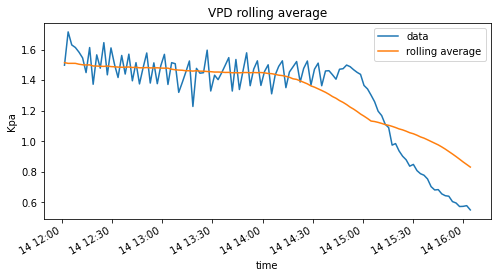

In [90]:
# %matplotlib widget

fig, ax = plt.subplots(1, figsize=(8,4))

# apply a rolling average of size "window_size",
# it can be either by number of points, or by window time
# window_size = 30  # number of measurements
window_size = '120min'  # minutes
VPD_smooth = df['VPD'].rolling(window_size, center=True).mean().to_frame()
VPD_smooth.rename(columns={'VPD': 'rolling_avg'}, inplace=True)
ax.plot(df['VPD'], color="tab:blue", label="data")
ax.plot(VPD_smooth['rolling_avg'], color="tab:orange", label="rolling average")
# add labels and title
ax.set(xlabel = "time",
       ylabel = "Kpa",
       title = "VPD rolling average")
# makes slanted dates
plt.gcf().autofmt_xdate()
ax.legend()